In [28]:
# import basic libraries
import os
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
import pyperclip
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json
import unicodedata


In [29]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

In [30]:
LAGT = pd.read_parquet("../../LAGT/data/large_files/LAGT_v4-0.parquet")

In [31]:
len(LAGT)

1958

In [32]:
source_dir = "../../LAGT/data/large_files/sents_data_jsons/"
len(os.listdir(source_dir))

1958

In [33]:
#test with the old approach...
lemmatized_sentences = [list(s) for work in LAGT[LAGT["lemmatized_sentences"].notnull()]["lemmatized_sentences"] for s in work]

In [34]:
# Normalize a string to a specified Unicode form
def norm(text):
    return unicodedata.normalize('NFC', text)

In [35]:
lemmatized_sentences = [[t for t in sent] for sent in lemmatized_sentences]

In [36]:
len(lemmatized_sentences)

2708257

In [37]:
lemmatized_sentences[:10]

[[],
 [],
 [],
 [],
 ['πινυτός', 'ἀντιγράφω'],
 ['θαυμάζω', 'ἀποδέχω', 'διονύσιος'],
 ['ἀντιπαρακαλέω', 'στεῤῥοτέρας', 'μεταδίδωμι', 'τροφή'],
 ['τελειοτέρω',
  'γράμμα',
  'λαός',
  'ὑποθρέψαντα',
  'διατέλος',
  'γαλακτώδεμι',
  'ἐνδιατρίβω',
  'λόγος',
  'νηπιώδης',
  'ἀγωγή',
  'λανθάνω',
  'καταγηράζω'],
 ['ἐπιστολή',
  'πινυτός',
  'πίστις',
  'ὀρθοδοξία',
  'φροντίς',
  'ὑπήκοος',
  'ὡφελεία',
  'λόγιον',
  'θεῖος',
  'σύνεσις'],
 ['ἀκριβεστάτης', 'ἀναδείκνυται', 'εἰκών']]

In [38]:
target = "ἐχθρός"
target_sentences = [sent for sent in lemmatized_sentences if target in sent]
len(target_sentences)

5749

In [39]:
LAGT.head()

,author_id,doc_id,filename,author,title,sentences,lemmatized_sentences,source,lemmata_source,not_before,not_after,tlg_epithet,genre,provenience,wordcount,lemmatacount
0,ogl0001,ogl0001.ogl001,ogl0001.ogl001.1st1K-grc1.xml,Pinytus,De Epistola Pinyti ad Dionysium,"[, , ., . . . . ., — πρός ἥν ( ,, ), ὁ Πινυτός...","[[], [], [], [], [πινυτός, ἀντιγράφω], [θαυμάζ...",glaux1,glaux1,101.0,200.0,[],None,christian,109,34
1,tlg0005,tlg0005.tlg003,tlg0005.tlg003.1st1K-grc1.xml,Theocritus,Syrinx,[Οὐδενός εὐνάτειρα Μακροπτολέμοιο δέ μάτηρ μαί...,"[[εὐνητήρ, μακροπτολέμον, μήτηρ, μαῖα, ἀντιπέτ...",glaux1,glaux1,-400.0,-201.0,[Bucolici],None,pagan,95,59
2,tlg0006,tlg0006.tlg020,tlg0006.tlg020.1st1K-grc1.xml,Euripides,Fragmenta,[ποίαν σε φῶμεν γαῖαν ἐκλελοιπότα πόλει ξενοῦσ...,"[[φημί, γῆ, ἐκλείπω, πόλις, ξενοῦσθαι], [πάτρα...",glaux1,glaux1,-500.0,-401.0,[Tragici],None,pagan,21516,10315
3,tlg0007,tlg0007.tlg146,tlg0007.tlg146.1st1K-grc1.xml,Plutarch,Παροιμίαι αἷς Ἀλεξανδρεῖς ἐχρῶντο,[Οἴκοι τά Μιλήσια: ἐπί τῶν ὅποι μή προςήκει τή...,"[[μιλήσιος, πργοςήκω, τρυφή, ἐπιδείκνυμι], [ἀρ...",glaux1,glaux1,1.0,200.0,"[Biographi, Philosophici/-ae]",None,pagan,3206,1496
4,tlg0007,tlg0007.tlg147,tlg0007.tlg147.1st1K-grc1.xml,Plutarch,Ἐκλογὴ περὶ τῶν ἀδυνάτων,"[Κατά πετρῶν σπείρεις., Πλίνθον πλύνεις., Δικτ...","[[πέτρα, σπείρω], [πλίνθος, πλύνω], [δίκτυον, ...",glaux1,glaux1,1.0,200.0,"[Biographi, Philosophici/-ae]",None,pagan,195,125


In [40]:
LAGT["lemmata_source"].unique()

array(['glaux1', 'grecy'], dtype=object)

In [41]:
(LAGT["lemmata_source"]=="glaux1").sum()

1698

In [42]:
#ids = LAGT["doc_id"].tolist()
ids = LAGT[(LAGT["provenience"]=="christian")]["doc_id"].tolist()
ids[:10]

['ogl0001.ogl001',
 'tlg0317.tlg001',
 'tlg0317.tlg002',
 'tlg0555.tlg002',
 'tlg0555.tlg005',
 'tlg0555.tlg007',
 'tlg0563.tlg001',
 'tlg0645.tlg001',
 'tlg0645.tlg002',
 'tlg0645.tlg003']

In [43]:
len(ids)

229

In [44]:
def load_sentence_data(ids):
    sents_data = []
    for id in ids:
        try:
            file_sents_data = json.load(open(source_dir + id + ".json", "rb"))
            sents_data.extend(file_sents_data)
        except:
            print("File with id {} not found".format(id))
    return sents_data


In [45]:
sentences_data = load_sentence_data(ids[:10])

In [46]:
len(sentences_data)

20777

In [47]:
# how many of the documents are actually from glaux?
len(set([d[0] for d in sentences_data if "tlg" not in d[0]]))

1

In [48]:
def get_target_sentences(ids, target_lemma, path=source_dir):
    target_sentences = []  
    not_found = []
    for id in ids:
        try:
            file_sents_data = json.load(open(path + id + ".json", "rb"))
            try:
                for fn, sent_n, sent_text, sent_data in file_sents_data:
                        #sent_data = [(norm(tup[0]), norm(tup[1]), tup[2], tup[3]) for tup in sent_data]
                        lemmata = [tup[1] for tup in sent_data]
                        if target_lemma in lemmata:
                            #sent_data = sents_data[sent_n]
                            target_sentences.append((id, sent_n, sent_text, sent_data))
            except:
                print("sentence data for file {} not found".format(id))
        except:
            not_found.append(id)
    return target_sentences

In [49]:
len(ids)

229

In [50]:
tar_sents = get_target_sentences(ids, "ἐχθρός")

In [51]:
len(tar_sents)

1648

In [52]:
example_sent_data = [sent for sent in tar_sents if "φησὶ δ’ ὅτι" in sent[2]][0]
example_sent_data

('tlg2042.tlg001',
 3430,
 'φησὶ δ’ ὅτι καὶ τὰ τοιάδε τις ποιεῖ πρὸς ἐχθροὺς, κίνδυνον ἐκφυγεῖν προμηθούμενος.',
 [['φησὶ', 'φημί', 'v', [0, 4]],
  ['δ’', 'δέ', 'c', [5, 7]],
  ['ὅτι', 'ὅτι', 'c', [8, 11]],
  ['καὶ', 'καί', 'c', [12, 15]],
  ['τὰ', 'ὁ', 'l', [16, 18]],
  ['τοιάδε', 'τοιόσδε', 'p', [19, 25]],
  ['τις', 'τις', 'p', [26, 29]],
  ['ποιεῖ', 'ποιέω', 'v', [30, 35]],
  ['πρὸς', 'πρός', 'r', [36, 40]],
  ['ἐχθροὺς', 'ἐχθρός', 'a', [41, 48]],
  [',', ',', 'u', [48, 49]],
  ['κίνδυνον', 'κίνδυνος', 'n', [50, 58]],
  ['ἐκφυγεῖν', 'ἐκφεύγω', 'v', [59, 67]],
  ['προμηθούμενος', 'προμηθέομαι', 'v', [68, 81]],
  ['.', '.', 'u', [81, 82]]])

In [153]:
# subselect by POS...
#tar_sents_nouns = []
#for sent_data in tar_sents:
#    if [tup for tup in sent_data[3] if (tup[1]=="liber") & (tup[2]=="NOUN")]:
#        tar_sents_nouns.append(sent_data)    

In [151]:
#len(tar_sents_nouns)

In [152]:
# subselect by a pattern in raw string
#sents_meta = [sent_data for sent_data in tar_sents if re.search("lib\w{2,3} natura",  sent_data[2])]

In [53]:
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def get_decontextualized_embeddings(word: str):
    input_ids = tokenizer.encode(word, add_special_tokens=False)
    word_emb = model.get_input_embeddings()
    embeddings = word_emb(torch.LongTensor(input_ids))
    return embeddings.mean(0).detach().numpy()

def get_embeddings_data(sent, tokenized_data):
    sent = strip_accents_and_lowercase(sent)
    inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512,
                       return_offsets_mapping=True)
    # Convert input_ids to actual tokens
    bert_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    #bert_tokens_ids = inputs['input_ids'][0].tolist()
    bert_tokens_offsets = inputs['offset_mapping'][0].tolist()
    # Separate the model inputs and offset_mapping
    model_inputs = {name: inputs[name] for name in ['input_ids', 'attention_mask']}
    with torch.no_grad():
        outputs = model(**model_inputs)
        bert_sentence_embeddings = outputs.last_hidden_state.mean(dim=1)
        bert_token_embeddings = outputs.last_hidden_state[0].detach().numpy()
    tokens_data = [(token, offset, embedding) for (token, offset, embedding) in zip(bert_tokens, bert_tokens_offsets, bert_token_embeddings)]

    tokens_data_updated = []
    for tup in tokens_data:
        if tup[0][0] == "Ġ": # if there is a space at the beginning
            tokens_data_updated.append((tup[0][1:], [tup[1][0] + 1, tup[1][1]], tup[2]))
        else:
            tokens_data_updated.append(tup)
    covered_tups = []
    for word_tuple in tokenized_data:
        covered_tokens = [tup[0] for tup in tokens_data_updated if word_tuple[-1][0] <= tup[1][0] < word_tuple[-1][1]]
        covered_embeddings = [tup[2] for tup in tokens_data_updated if word_tuple[-1][0] <= tup[1][0] < word_tuple[-1][1]]
        if covered_embeddings:
            embedding_avg = np.mean(covered_embeddings, axis=0)
        else:
            embedding_avg = np.zeros(768)
        embedding_decontext = get_decontextualized_embeddings(word_tuple[0])
        # Reshape vectors to 2D arrays
        embedding_avg_2d = embedding_avg.reshape(1, -1)
        embedding_decontext_2d = embedding_decontext.reshape(1, -1)
        # Compute cosine similarity and pick the number at first row and column
        if np.isnan(embedding_avg).any() or np.isnan(embedding_decontext).any():
            # handle the issue, for example, skip the similarity calculation for this pair
            similarity_score = None
        else:
            similarity_score = cosine_similarity(embedding_avg_2d, embedding_decontext_2d)[0, 0]
        covered_tups.append((word_tuple[0], word_tuple[1], word_tuple[2], word_tuple[3], covered_tokens, covered_embeddings, embedding_avg, embedding_decontext, similarity_score))
    df = pd.DataFrame(covered_tups, columns=["spacy_tokens", "spacy_lemma", "spacy_pos", "spacy_position", "bert_tokens", "bert_tok_emb", "bert_avg_emb", "bert_avg_decontext", "cos_sim"])
    return bert_sentence_embeddings, df

In [55]:
sent = example_sent_data[2]
sent

'φησὶ δ’ ὅτι καὶ τὰ τοιάδε τις ποιεῖ πρὸς ἐχθροὺς, κίνδυνον ἐκφυγεῖν προμηθούμενος.'

In [56]:
inputs = tokenizer(strip_accents_and_lowercase(sent), return_tensors='pt', padding=True, truncation=True, max_length=512,
                       return_offsets_mapping=True)
# Convert input_ids to actual tokens
bert_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
bert_tokens

['[CLS]',
 'φ',
 '##η',
 '##σι',
 'δ',
 '’',
 'οτι',
 'και',
 'τα',
 'το',
 '##ια',
 '##δε',
 'τις',
 'ποι',
 '##ει',
 'προς',
 'εχθρους',
 ',',
 'κινδυνο',
 '##ν',
 'εκ',
 '##φυγε',
 '##ιν',
 'προ',
 '##μη',
 '##θουμε',
 '##νος',
 '.',
 '[SEP]']

In [57]:
tokenized_data = example_sent_data[3]
tokenized_data

[('φησὶ', 'φημί', 'v', (0, 4)),
 ('δ’', 'δέ', 'c', (5, 7)),
 ('ὅτι', 'ὅτι', 'c', (8, 11)),
 ('καὶ', 'καί', 'c', (12, 15)),
 ('τὰ', 'ὁ', 'l', (16, 18)),
 ('τοιάδε', 'τοιόσδε', 'p', (19, 25)),
 ('τις', 'τις', 'p', (26, 29)),
 ('ποιεῖ', 'ποιέω', 'v', (30, 35)),
 ('πρὸς', 'πρός', 'r', (36, 40)),
 ('ἐχθροὺς', 'ἐχθρός', 'a', (41, 48)),
 (',', ',', 'u', (48, 49)),
 ('κίνδυνον', 'κίνδυνος', 'n', (50, 58)),
 ('ἐκφυγεῖν', 'ἐκφεύγω', 'v', (59, 67)),
 ('προμηθούμενος', 'προμηθέομαι', 'v', (68, 81)),
 ('.', '.', 'u', (81, 82))]

In [58]:
sent[50:58]

'κίνδυνον'

In [59]:
# sent = "Nulla res humana maior est quam scientia, quae hominem ad altiora perducit et ad sapientiam veram dirigit."
sentence_emb, df = get_embeddings_data(sent, tokenized_data)
df

,spacy_tokens,spacy_lemma,spacy_pos,spacy_position,bert_tokens,bert_tok_emb,bert_avg_emb,bert_avg_decontext,cos_sim
0,φησὶ,φημί,v,"(0, 4)","[[CLS], φ, ##η, ##σι, [SEP]]","[[0.126773, -1.1460568, -0.36589924, -0.442628...","[0.055630244, -1.0399504, 0.13653222, -0.40195...","[-0.012096606, -0.030440113, 0.017067729, -0.0...",0.204228
1,δ’,δέ,c,"(5, 7)","[δ, ’]","[[0.42961082, -0.26498458, 0.5563413, -0.83875...","[-0.01887469, -0.94238377, 0.45913512, -0.2678...","[0.011575137, -0.0151775805, 0.023164673, 0.02...",0.138626
2,ὅτι,ὅτι,c,"(8, 11)",[οτι],"[[-0.4615304, -0.31729072, -0.022057451, 0.861...","[-0.4615304, -0.31729072, -0.022057451, 0.8617...","[-0.01677258, -0.032124057, 0.0044609103, 0.00...",0.245822
3,καὶ,καί,c,"(12, 15)",[και],"[[1.5651153, -0.95122683, -0.13586602, 1.03799...","[1.5651153, -0.95122683, -0.13586602, 1.037991...","[-0.0030805555, -0.033028033, 0.008152605, 0.0...",0.214087
4,τὰ,ὁ,l,"(16, 18)",[τα],"[[0.2499441, -0.9689746, -0.3689912, 0.1693185...","[0.2499441, -0.9689746, -0.3689912, 0.1693185,...","[-0.038830634, -0.030820807, -0.06507481, -0.0...",0.227680
5,τοιάδε,τοιόσδε,p,"(19, 25)","[το, ##ια, ##δε]","[[0.45228642, -0.7595569, -0.06168846, 1.11692...","[0.60097176, -1.297628, 0.39050913, 0.30290803...","[0.0029496206, 0.009914069, 0.0108285025, -0.0...",0.168827
6,τις,τις,p,"(26, 29)",[τις],"[[-0.57688993, 0.02323033, -0.15997607, -0.460...","[-0.57688993, 0.02323033, -0.15997607, -0.4609...","[-0.07167294, 0.04119083, 0.016016362, 0.03935...",0.152493
7,ποιεῖ,ποιέω,v,"(30, 35)","[ποι, ##ει]","[[0.18136965, -0.34368002, 1.2247267, 0.791617...","[0.09676672, -0.6370541, 1.1661888, 0.911531, ...","[-0.029717272, -0.001931034, 0.032189313, -0.0...",0.181978
8,πρὸς,πρός,r,"(36, 40)",[προς],"[[-0.81442326, 0.24669549, 0.13024646, 1.30324...","[-0.81442326, 0.24669549, 0.13024646, 1.303248...","[0.005379804, 0.0018558903, -0.016126659, 0.06...",0.222416
9,ἐχθροὺς,ἐχθρός,a,"(41, 48)",[εχθρους],"[[0.9549469, -1.0772797, 0.93842745, -0.359743...","[0.9549469, -1.0772797, 0.93842745, -0.3597439...","[0.0026509743, -0.04798743, -0.061518624, 0.05...",0.178552


In [60]:
len(tar_sents)

727

In [61]:
%%time
sents_dfs = []
for sent_data in tar_sents:
    sent_emb, df = get_embeddings_data(sent_data[2], sent_data[3])
    sents_dfs.append((sent_data[0], sent_data[1], sent_data[2], sent_emb, df))

CPU times: user 1min 51s, sys: 9.76 s, total: 2min 1s
Wall time: 32.9 s


In [64]:
sentences = [sent_data[2] for sent_data in sents_dfs]
sentences[:3]

['ὀφθαλμός ἐχθρῶν ἔπληξέ με·',
 'ὑμέρας ‖ μέρος ‖ ἤ ‖ ἐν παῤ αἰτῶ Δ ἀλλά πυρί αἰωνίω παραδοθήσεσθε ἐν δέ φυλάξησθε καί πῦρ αἰώ- νιον καί τόν ἐχθρόν σατάν καί τά αὐτοῦ ἔνεδρα ἐκφεύξησθε καί ζωήν αἰώνιον ἐν οὐρανοῖς λήψεσθε ‖ ταῦτα εἰπών ‖ πρ.',
 'ὁ δείξας αὐτῇ τόν ἔδιον ἐχθρόν·']

In [65]:
target = "ἐχθρός"
target_vectors = [] 
for sent_data in sents_dfs:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [66]:
target_embeddings = np.vstack(target_vectors)
cosine_sim_matrix = pd.DataFrame(cosine_similarity(target_embeddings), index=sentences, columns=sentences)

In [67]:
sentence_embeddings = [s[3][0] for s in sents_dfs]
sentence_embeddings_vstack = np.vstack(sentence_embeddings)
cosine_sim_matrix_sent = pd.DataFrame(cosine_similarity(sentence_embeddings_vstack), index=sentences, columns=sentences)

In [68]:
tsne = TSNE(n_components=1, perplexity=10)
embeddings_tsne = tsne.fit_transform(target_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
len(embeddings_tsne)

727

In [70]:
tar_sents_ids = [d[0] for d in sents_dfs]
tar_sents_ids[:5]

['tlg0317.tlg001',
 'tlg0317.tlg001',
 'tlg0317.tlg001',
 'tlg0555.tlg002',
 'tlg0555.tlg002']

In [73]:
def get_avg_years(doc_id):
    row_dict = LAGT[LAGT["doc_id"]==doc_id].iloc[0].to_dict()
    try:
        return int((row_dict["not_before"] + row_dict["not_after"]) / 2)
    except:
        return None

In [74]:
years = [get_avg_years(id) for id in tar_sents_ids]
years[:5]

[150, 150, 150, 200, 200]

(1.0, 400.0)

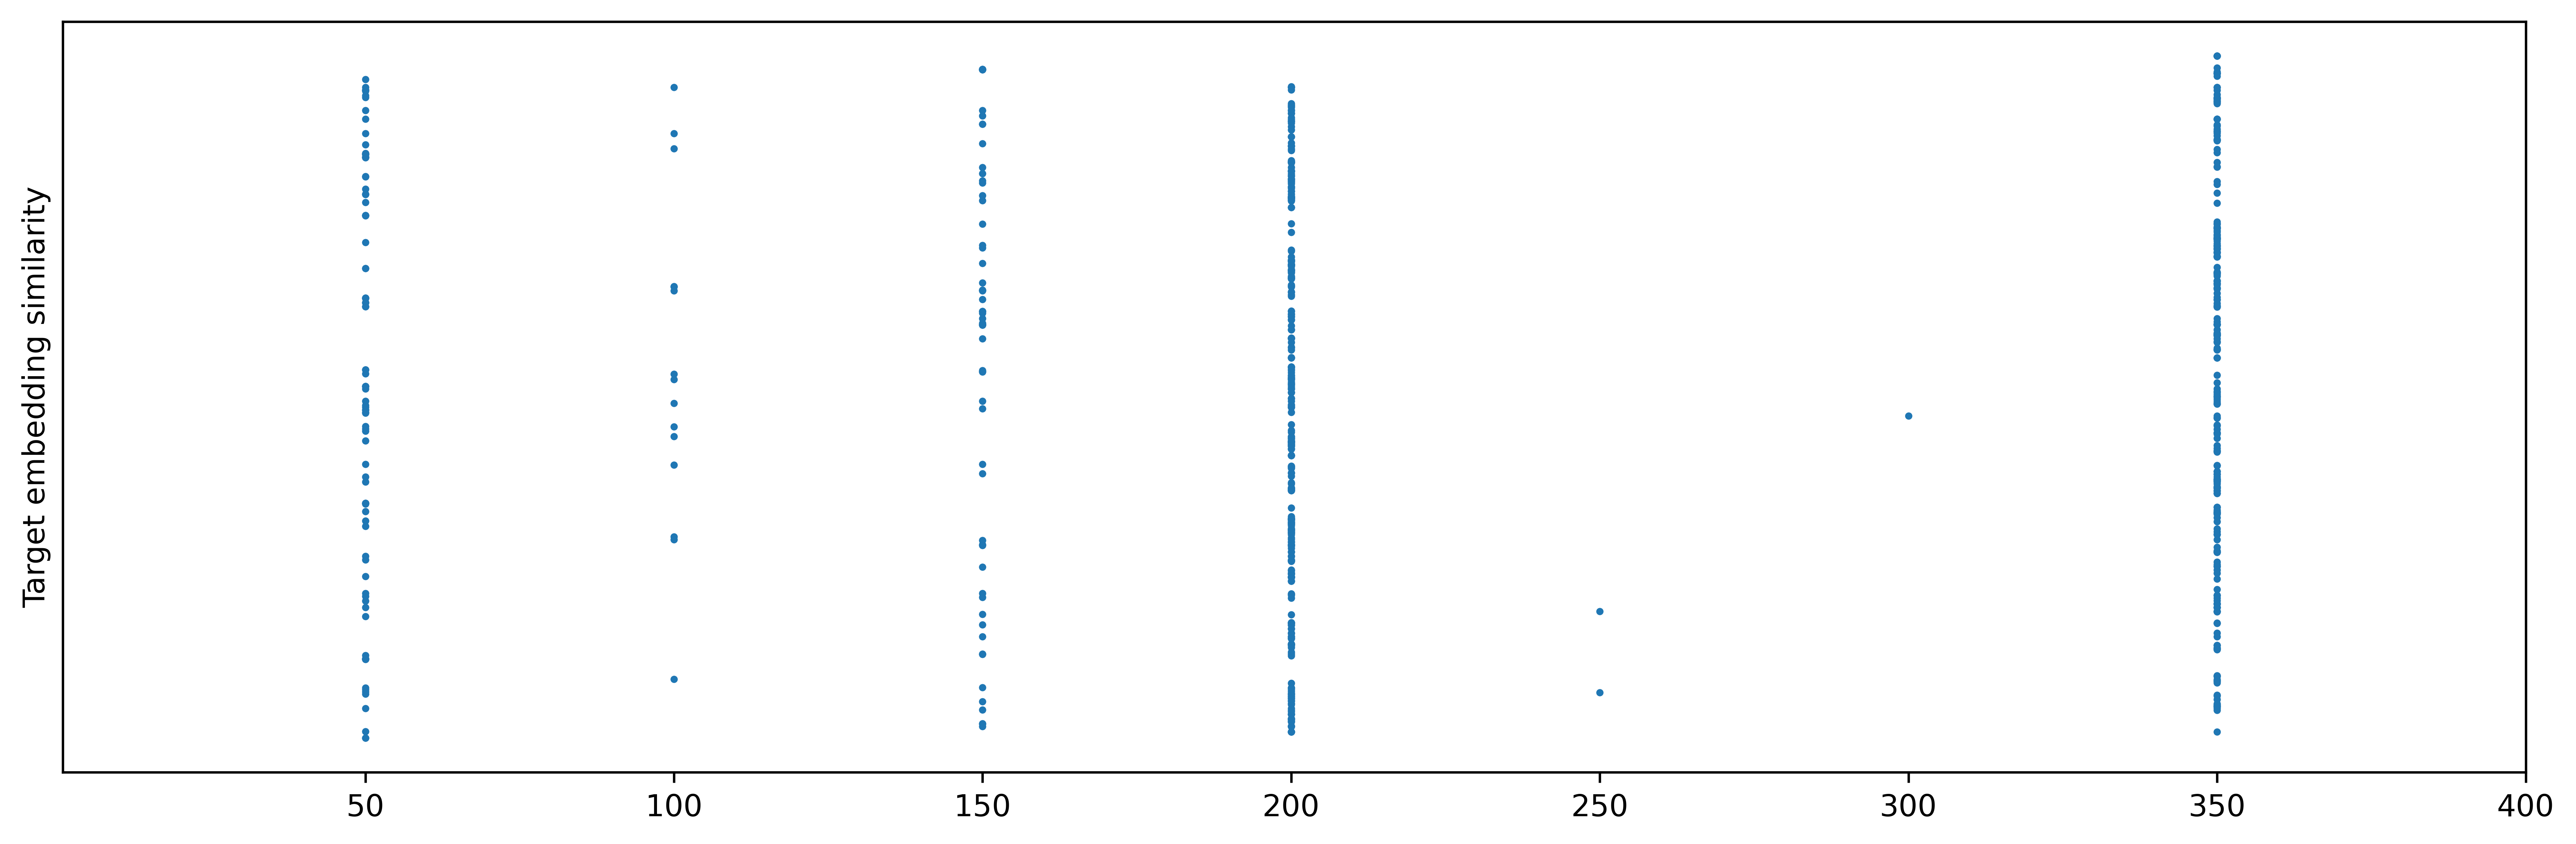

In [80]:
fig, ax = plt.subplots(tight_layout=True, dpi=600, figsize=(12,4))
ax.scatter(x=years, y=embeddings_tsne, s=2)# You may want to adjust the size depending on your similarity matrix
ax.set_yticks([])
ax.set_ylabel("Target embedding similarity")
ax.set_xlim(1, 400)

In [87]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(target_embeddings)
labels = kmeans.labels_
cluster_colors = {0: "#1f77b4",  # muted blue
                  1: "#ff7f0e",  # safety orange
                  2: "#2ca02c",  # cooked asparagus green
                  3: "#d62728",  # brick red
                  4: "#9467bd"}
colors = [cluster_colors[l] for l in labels]

(1.0, 500.0)

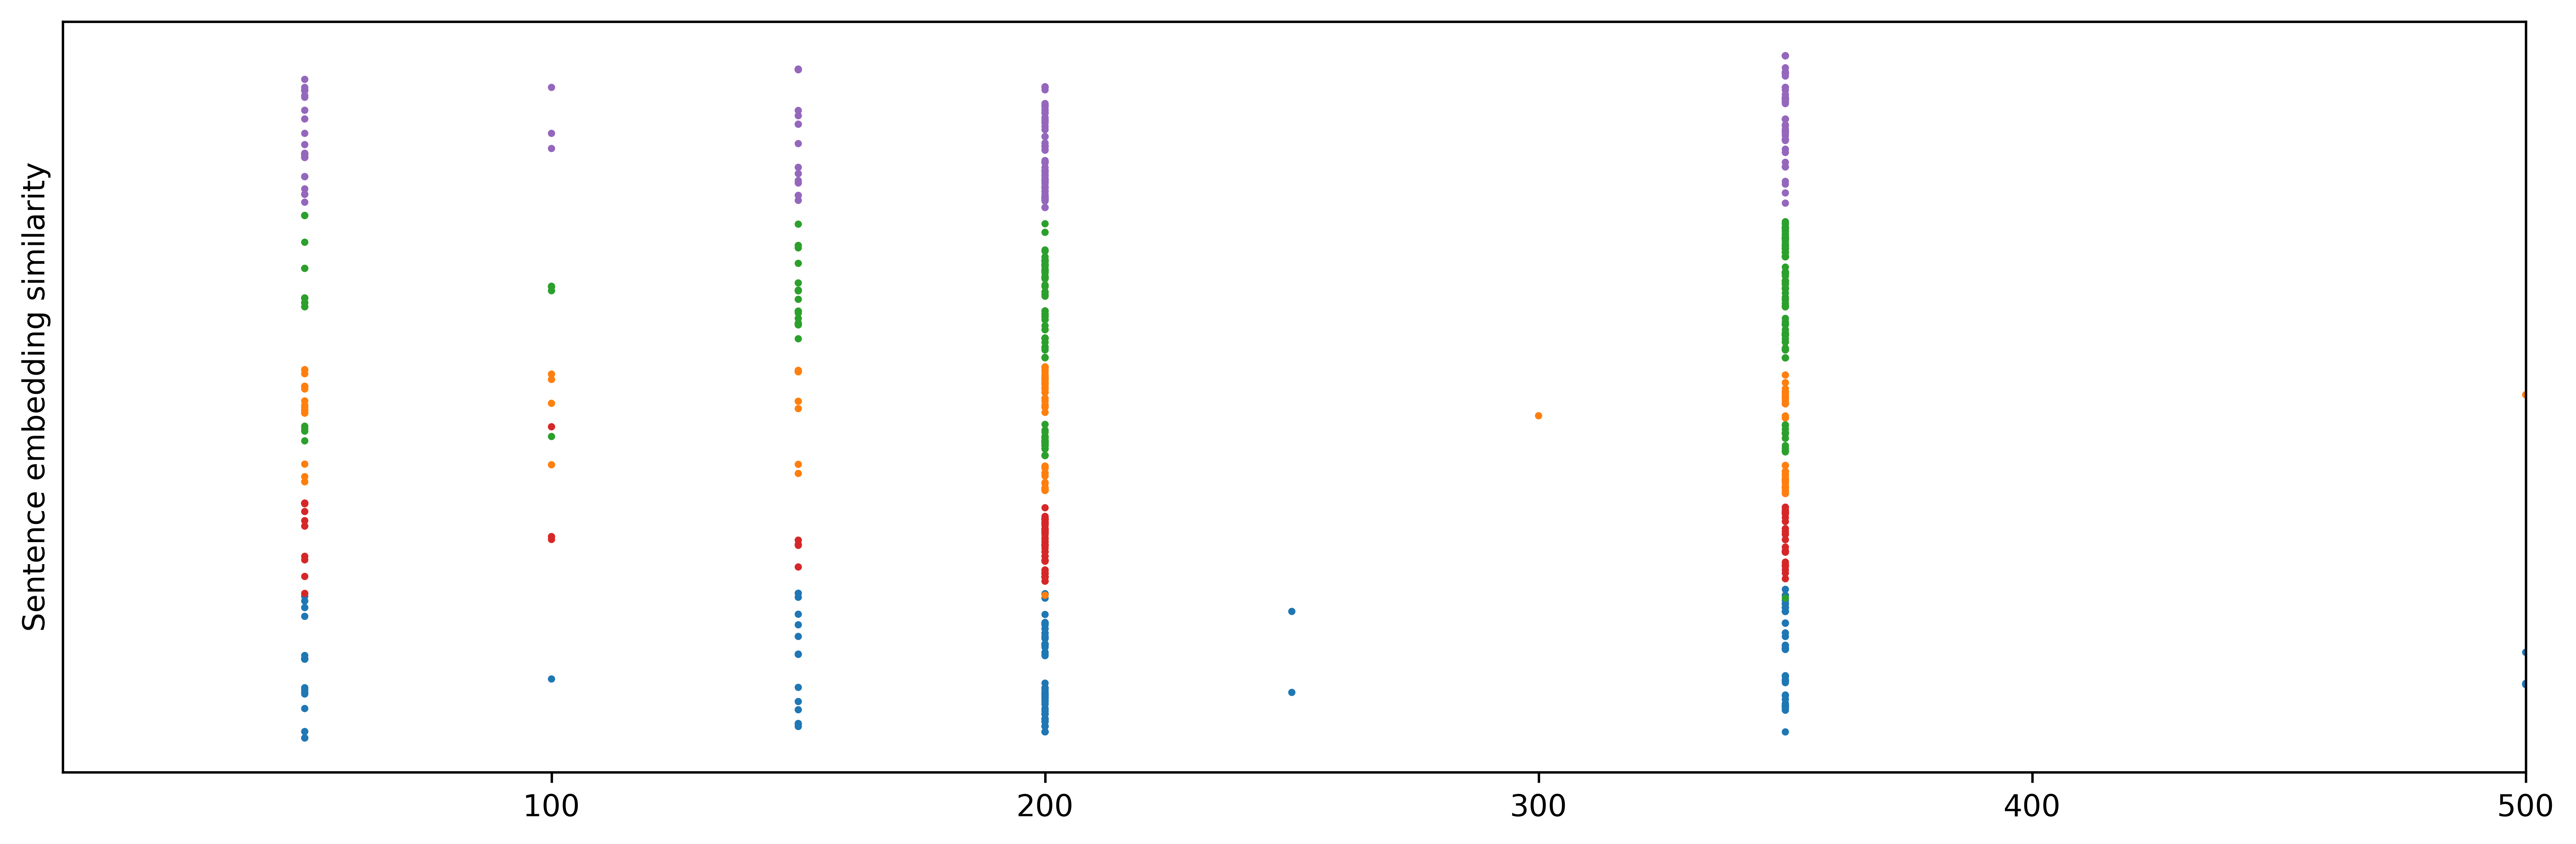

In [88]:
fig, ax = plt.subplots(tight_layout=True, dpi=600, figsize=(12,4))
ax.scatter(x=years, y=embeddings_tsne, c=colors, s=2)# You may want to adjust the size depending on your similarity matrix
ax.set_yticks([])
ax.set_ylabel("Sentence embedding similarity")
ax.set_xlim(1, 500)

In [89]:
fig.savefig("../figures/ekthros_tsne_1d+time.png")

In [91]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(target_vectors)
labels = kmeans.labels_

In [92]:
len(labels)

727

In [93]:
print(labels[:20])

[2 0 0 3 1 3 4 0 2 3 3 3 0 3 0 2 0 0 2 2]


In [94]:
cluster_colors = {0: "#1f77b4",  # muted blue
                  1: "#ff7f0e",  # safety orange
                  2: "#2ca02c",  # cooked asparagus green
                  3: "#d62728",  # brick red
                  4: "#9467bd"}  # muted purple

In [95]:
colors = [cluster_colors[l] for l in labels]

In [96]:
target_embeddings = np.vstack(target_vectors)
cosine_sim_matrix = pd.DataFrame(cosine_similarity(target_embeddings), index=sentences, columns=sentences)

In [97]:
cosine_sim_matrix.iloc[8].sort_values(ascending=False)

καὶ ὁ Μίδας ὀδύρεται τὸν πλοῦτον, καὶ ποεῖται παλινῳδίαν τῆς εὐχῆς, καὶ εὔχεται Σατύρῳ μὲν οὐκέτι, θεοῖς δὲ καὶ θεαῖς, ἐλθεῖν αὐτῷ τὴν ἀρχαίαν πενίαν, τὴν εὔφορον ἐκείνην καὶ πάμφορον καὶ καρποτρόφον, τὸν δὲ χρυσὸν ἀπελθεῖν εἰς ἐχθρῶν κεφαλάς. E                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [101]:
tsne = TSNE(n_components=3, perplexity=5)
embeddings_tsne = tsne.fit_transform(np.vstack(target_vectors))

In [102]:
xs = embeddings_tsne[:, 0]
ys = embeddings_tsne[:, 1]
zs = embeddings_tsne[:, 2]

In [104]:
def insert_newlines(input_str, word_count=10):
    words = input_str.split(' ')
    for i in range(word_count - 1, len(words), word_count):
        words[i] = words[i] + '<br>'
    return ' '.join(words)
hover_text = [insert_newlines(sent) + " ({0})".format(id) for sent, id in zip(sentences, tar_sents_ids)]

In [108]:
title = "Sentences with 'ἐχθρός' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [109]:
pio.write_html(fig, file="../figures/ekthros-sample.html")

In [110]:
xs = years

title = "Sentences with 'ἐχθρός' (N={}) - diachronic".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='year', showbackground=False, showgrid=True, showline=True), #showline=True, showticklabels=True, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        #xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [111]:
pio.write_html(fig, file="../figures/ekthros-diachronic.html")
